# 2-Point Correlation Function (2PCF) analysis 

In this notebook we perform the main analysis using 2PCFs in pregnant women at ANC visits and comparing parasitological with serological data. 

Main analysis:

1- 2PCF measurements: 2PCF statistics will be obtained for the three years data separately, cross-correlating PCR data with serological data for the different antigens using all pregnant women at first ANC.

2- Consistency analysis: a t-test will be used to measure the statistical significance of the clustering signal of the different populations by measuring the deviation of the 2PCFs from zero. A table will be created describing the p-values of each population and year to identify the most significant clustering structures found. 

## Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from spatial_tools import clustering, visualise
from stat_tools import errors
import contextily as ctx
from pregmal_pytools import spatial_utils
from stat_tools import stats
from time import time
import scipy.stats as sci_stats

## Importing data 

In [2]:
mipmon, cross, cross210, antigens = spatial_utils.import_spatial_data()

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py:290: Se

## Define masks and other definitions

In [3]:
#MiPMon masks
has_geo_mip = mipmon['latitude'].notnull()&mipmon['longitude'].notnull()
has_pcr_mip = mipmon['pcrpos'].notnull()&has_geo_mip
mip_pcrpos = mipmon['pcrpos'] == 1
mip_pcrneg = mipmon['pcrpos'] == 0
mip_rdtpos = mipmon['density'] >= 100
mip_rdtneg = mipmon['density'] < 100
prenatal = (mipmon['visit'] == 'PN')&has_pcr_mip

#Define masks for MiPMon data
mipmon_pn = prenatal&has_pcr_mip
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_sg = mipmon_pn&(mipmon['gestnum'] == 2)
mipmon_12g = mipmon_pn&(mipmon['gestnum'] <= 2)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_3g = mipmon_pn&(mipmon['gestnum'] > 2)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'All ANC visits' : mipmon_pn,
    'Primigravidae' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'Multigravidae' : mipmon_mg,
    'HIV+' : mipmon_hiv_pos,
    'HIV-' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'Primigravid HIV-' : mipmon_pg_hiv_neg,
}

#Cross masks
cross210_area_mask = (cross210['area'] == 'Magude Sede')|(cross210['area'] == 'Manhiça')|(cross210['area'] == 'Ilha Josina')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Taninga')|(cross210['area'] == 'Panjane')
cross210_area_mask = cross210_area_mask |(cross210['area'] == 'Palmeira')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Maragra')|(cross210['area'] == 'Malavele')
has_geo_cross = cross['lat'].notnull()&cross['lng'].notnull()
has_pcr_cross = cross['pospcr'].notnull()&has_geo_cross
has_rdt_cross = cross['rdt'].notnull()&has_geo_cross
cross_pcrpos = cross['pospcr'] == 1
cross_pcrneg = cross['pospcr'] == 0
cross_rdtpos = cross['rdt'] == 1
cross_rdtneg = cross['rdt'] == 0

has_geo_cross210 = cross210['lat'].notnull()&cross210['lng'].notnull()
has_pcr_cross210 = cross210['pospcr'].notnull()&has_geo_cross210
has_rdt_cross210 = cross210['rdt'].notnull()&has_geo_cross210
cross210_pcrpos = cross210['pospcr'] == 1
cross210_pcrneg = cross210['pospcr'] == 0
cross210_rdtpos = cross210['rdt'] == 1
cross210_rdtneg = cross210['rdt'] == 0


#Colour palette for MiPMon selections
colors_mipmon = [cm.turbo((i+1)/float(len(antigens) + 1)) for i in range(len(antigens) + 1)]

#years = [2017, 2018, 2019]
years = [1, 2, 3]

# Analysis 

###Chosen 2PCF parameters 

In [4]:
#Number of spatial bins
bins = 10
#Spatial range of scale in Km
ranges = [.0,60.]
#Number of random realisations
nrands = 20


### 2PCF measurements 
 

In [5]:
def get_2pcf_cross(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                   get_error = True, show = True, lw = 2):
    #Defining input data from cross-sectional 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['lng'])
    y1 = np.array(dataframe[mask&pcrpos]['lat'])
    x2 = np.array(dataframe[mask]['lng'])
    y2 = np.array(dataframe[mask]['lat'])
    w1 = np.array(dataframe[mask&pcrpos]['weight'])
    w2 = np.array(dataframe[mask]['weight'])
    
    #Run 2PCF for cross-sectional
    cross_2pcf, mean_bin_cross, edges, cross_err = clustering.correlation_function(x1, y1, x2, y2, \
                                                                                bins = bins, \
                                                                                ranges = ranges, \
                                                                                get_error=get_error, \
                                                                                nrands = nrands, \
                                                                                w1 = w1, w2 = w2)
    #Plotting results for non-empty data
    mask_empty_bins = (cross_2pcf**2>=0)&(cross_err**2>=0)
    if show:
        plt.errorbar(mean_bin_cross[mask_empty_bins], cross_2pcf[mask_empty_bins], \
                     cross_err[mask_empty_bins], c = 'k', label = "Children 2-10", \
                    linestyle = '--', lw = lw)
    return cross_2pcf, mean_bin_cross, edges, cross_err

def get_2pcf_pcr(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                 get_error = True, show = True, lw = 2):
    #Defining input data from cross-sectional 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['longitude'])
    y1 = np.array(dataframe[mask&pcrpos]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    
    #Run 2PCF for cross-sectional
    cross_2pcf, mean_bin_cross, edges, cross_err = clustering.correlation_function(x1, y1, x2, y2, \
                                                                                bins = bins, \
                                                                                ranges = ranges, \
                                                                                get_error=get_error, \
                                                                                nrands = nrands, \
                                                                                w1 = w1, w2 = w2)
    #Plotting results for non-empty data
    mask_empty_bins = (cross_2pcf**2>=0)&(cross_err**2>=0)
    if show:
        plt.errorbar(mean_bin_cross[mask_empty_bins], cross_2pcf[mask_empty_bins], \
                     cross_err[mask_empty_bins], c = 'k', label = "qPCR data", linestyle = '--', \
                    lw = lw)
    return cross_2pcf, mean_bin_cross, edges, cross_err

def get_2pcf_mipmon(dataframe, pcrpos, antigen, mask, bins, ranges, nrands, \
                    colour, get_error = True, show = True, label = '', mode = 'auto', lw = 2):#TODO define mode {'auto', 'cross'}
    #Defining input data from ANC 2PCFs
    #TODO make this cross between pcrpos and antigens
    x1 = np.array(dataframe[mask&antigen]['longitude'])
    y1 = np.array(dataframe[mask&antigen]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    #TODO define x1x, y1x, as [mask&antigen] if mode == 'cross', as None if mode == 'auto'
    if mode == 'cross':
        x1x = np.array(dataframe[mask&pcrpos]['longitude'])
        y1x = np.array(dataframe[mask&pcrpos]['latitude'])
    elif mode == 'auto':
        x1x, y1x = None, None
    else:
        print("WARNING: invalid value of mode", mode, ", assuming auto")
        x1x, y1x = None, None
    
    #Run 2PCF for ANC
    #TODO make this cross between pcrpos and antigens
    mip_2pcf, mean_bin_mip, edges, \
    mip_err = clustering.correlation_function(x1, y1, x2, y2, \
                                              bins = bins, ranges = ranges, \
                                              get_error=get_error, \
                                              nrands = nrands, \
                                              w1 = w1, w2 = w2, x1x = x1x, y1x = y1x)#TODO TEST
    #Plotting results for non-empty data
    mask_empty_bins = (mip_2pcf**2>=0)&(mip_err**2>=0)
    if show:
        plt.errorbar(mean_bin_mip[mask_empty_bins], mip_2pcf[mask_empty_bins], \
                     mip_err[mask_empty_bins], c = colour, label = label, lw = lw)
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_2pcf_antigens(dataframe, pcrpos, antigens, mask, bins, ranges, nrands, \
                               colours, get_error = True, show = True, mode = 'auto', lw = 2):#TODO define mode {'auto', 'cross'}
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    for c, s in enumerate(antigens):
        #Run 2PCF for ANC
        mip_2pcf[s], mean_bin_mip[s], edges[s], \
        mip_err[s] = get_2pcf_mipmon(dataframe, pcrpos, np.array(dataframe[s]) == 1, mask, \
                                             bins, ranges, get_error=get_error, nrands = nrands, \
                                             colour = colours[c], label = s[4:], mode = mode, lw = lw)#TODO TEST
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_all_2pcf_years(mipmon_df, mip_pcrpos, antigens, mip_mask, cross_df, cross_pcrpos, cross_mask, bins, \
                       ranges, nrands, colors_mipmon, colour_cross, get_error = True, show = True, verbose = False, \
                       time_width = None, figsize = None, mode = 'auto', ylims = None, ncol = 2, lw = 2, \
                      cross_pop = 'mipmon'):
    #Dictionary to store results from ANC data
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    cross_2pcf, mean_bin_cross, edges, cross_err  = {}, {}, {}, {}
    
    for y in years:
        plt.figure(figsize = figsize)
        #Mask to select the year of the data
        cross_mask_time, mip_mask_time = get_time_masks(cross_df, mipmon_df, y, time_width = time_width)
        
        #Run 2PCF for all ANC selections
        if verbose:
            print('Sample size serological data:', np.sum(mip_mask_time&mip_mask))
        mip_2pcf[str(y)], mean_bin_mip[str(y)], edges[str(y)], mip_err[str(y)] = \
        get_2pcf_antigens(mipmon_df, mip_pcrpos, antigens, mip_mask_time&mip_mask, \
                          bins, ranges, nrands, colors_mipmon, get_error = get_error, \
                          show = show, mode = mode, lw = lw)#TODO TEST
        
        
        
        #Run 2PCF for cross-sectional
        if verbose:
            print('Sample size PCR data:', np.sum(cross_mask_time&cross_mask))
        if cross_pop == 'mipmon':
            cross_2pcf[str(y)], mean_bin_cross[str(y)], edges[str(y)], cross_err[str(y)] = \
            get_2pcf_pcr(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                         ranges, nrands, colour_cross, get_error = get_error, show = show, \
                        lw = lw)
        elif cross_pop == 'cross':
            get_2pcf_cross(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                         ranges, nrands, colour_cross, get_error = get_error, show = show, \
                        lw = lw)
        
        
        plt.hlines(0, ranges[0] - 2, ranges[1] + 2, color = 'tab:grey')
        plt.xlim(ranges[0] - 2, ranges[1] + 2)
        #plt.legend(ncol = ncol)
        plt.xlabel('r (Km)')
        plt.ylabel(r'$\xi(r)$ year '+ str(y))
        #plt.title("2PCF year "+ str(y))
        plt.ylim(ylims)
        plt.show()
    return mip_2pcf, mean_bin_mip, edges, mip_err, cross_2pcf, mean_bin_cross, edges, cross_err

def get_time_masks(cross_df, mipmon_df, year, time_width = None, verbose = False):
    #Mask to select the year of the data
    cross_mask = cross_df['year'] == year
    if verbose:
        print('Sample size cross-sectional:', np.sum(cross_mask))
    if time_width is None:
        mip_mask = mipmon_df['year'] == year
    else:
        mean_cross_data = cross_df['visdate'][cross_mask].mean()
        mip_mask = get_time_mask_mipmon(mipmon_df, mean_cross_data, time_width, verbose = verbose)
    return cross_mask, mip_mask

def get_time_mask_mipmon(mipmon_df, date, time_width, verbose = True):
    #Selection a window aroung the cross-sectional data for ANC
    time_0 = date - pd.to_timedelta(time_width/2, unit = 'D')
    time_1 = date + pd.to_timedelta(time_width/2, unit = 'D')
    mip_mask = (mipmon_df['visdate'] >= time_0)&(mipmon_df['visdate'] <= time_1)
    if verbose:
        print('Sample size all 1st ANC:', np.sum(mip_mask))
    return mip_mask

In [6]:
def get_2pcf_mipmon_cross(dataframe, pcrpos, mask, bins, ranges, nrands, colour, \
                    get_error = True, show = True, label = '', mode = 'auto', \
                    cross_df = None, cross_pcrpos = None, cross_mask = None, \
                   lw = 2):
    #Defining input data from ANC 2PCFs
    x1 = np.array(dataframe[mask&pcrpos]['longitude'])
    y1 = np.array(dataframe[mask&pcrpos]['latitude'])
    x2 = np.array(dataframe[mask]['longitude'])
    y2 = np.array(dataframe[mask]['latitude'])
    w1 = None
    w2 = None
    if mode == 'cross':
        x1x = np.array(cross_df[cross_mask&cross_pcrpos]['lng'])
        y1x = np.array(cross_df[cross_mask&cross_pcrpos]['lat'])
        x2x = np.array(cross_df[cross_mask]['lng'])
        y2x = np.array(cross_df[cross_mask]['lat'])
        w1x = np.array(cross_df[cross_mask&cross_pcrpos]['weight'])
        w2x = np.array(cross_df[cross_mask]['weight'])
    elif mode == 'auto':
        x1x, y1x, x2x, y2x, w1x, w2x = None, None, None, None, None, None
    else:
        print("WARNING: invalid value of mode", mode, ", assuming auto")
        x1x, y1x, x2x, y2x, w1x, w2x = None, None, None, None, None, None
    
    #Run 2PCF for ANC
    mip_2pcf, mean_bin_mip, edges, \
    mip_err = clustering.correlation_function(x1, y1, x2, y2, \
                                              bins = bins, ranges = ranges, \
                                              get_error=get_error, \
                                              nrands = nrands, \
                                              w1 = w1, w2 = w2, \
                                              x1x = x1x, y1x = y1x, \
                                              x2x = x2x, y2x = y2x, w1x = w1x, w2x = w2x)
    #Plotting results for non-empty data
    mask_empty_bins = (mip_2pcf**2>=0)&(mip_err**2>=0)
    if show:
        plt.errorbar(mean_bin_mip[mask_empty_bins], mip_2pcf[mask_empty_bins], \
                     mip_err[mask_empty_bins], c = colour, label = label, lw = lw)
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_2pcf_antigens_cross(dataframe, pcrpos, antigens, mask, bins, ranges, nrands, \
                               colours, get_error = True, show = True, mode = 'auto', \
                               cross_df = None, cross_pcrpos = None, cross_mask = None, \
                            lw = 2):#TODO define mode {'auto', 'cross'}
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    for c, s in enumerate(antigens):
        #Run 2PCF for ANC
        mip_2pcf[s], mean_bin_mip[s], edges[s], \
        mip_err[s] = get_2pcf_mipmon_cross(dataframe, pcrpos, np.array(dataframe[s]) == 1, \
                                             bins, ranges, nrands = nrands, colour = colours[c], \
                                             get_error=get_error, label = s[4:], mode = mode, \
                                    cross_df = cross_df, cross_pcrpos = cross_pcrpos, \
                                     cross_mask = cross_mask, lw = lw)#TODO TEST
    return mip_2pcf, mean_bin_mip, edges, mip_err

def get_all_2pcf_years_sero_cross(mipmon_df, mip_pcrpos, antigens, mip_mask, cross_df, cross_pcrpos, cross_mask, bins, \
                       ranges, nrands, colors_mipmon, colour_cross, get_error = True, show = True, verbose = False, \
                       time_width = None, figsize = None, mode = 'auto', ylims = None, ncol = 2, lw = 2, \
                                 fontsize = None, legend = True):
    #Dictionary to store results from ANC data
    mip_2pcf, mean_bin_mip, edges, mip_err = {}, {}, {}, {}
    cross_2pcf, mean_bin_cross, edges, cross_err  = {}, {}, {}, {}
    
    for y in years:
        plt.figure(figsize = figsize)
        #Mask to select the year of the data
        cross_mask_time, mip_mask_time = get_time_masks(cross_df, mipmon_df, y, time_width = time_width)
        
        #Run 2PCF for all ANC selections
        if verbose:
            print('Sample size serological data:', np.sum(mip_mask_time&mip_mask))
        mip_2pcf[str(y)], mean_bin_mip[str(y)], edges[str(y)], mip_err[str(y)] = \
        get_2pcf_antigens_cross(mipmon_df, mip_pcrpos, antigens, mip_mask_time&mip_mask, \
                          bins, ranges, nrands, colors_mipmon, get_error = get_error, \
                          show = show, mode = mode, cross_df = cross_df, \
                                   cross_pcrpos = cross_pcrpos, \
                                   cross_mask = cross_mask_time&cross_mask, lw = lw)#TODO TEST
        
        
        
        #Run 2PCF for cross-sectional
        if verbose:
            print('Sample size PCR data:', np.sum(cross_mask_time&cross_mask))
        cross_2pcf[str(y)], mean_bin_cross[str(y)], edges[str(y)], cross_err[str(y)] = \
        get_2pcf_cross(cross_df, cross_pcrpos, cross_mask_time&cross_mask, bins, \
                         ranges, nrands, colour_cross, get_error = get_error, show = show, \
                    lw = lw)
        
        
        plt.hlines(0, ranges[0] - 2, ranges[1] + 2, color = 'tab:grey')
        plt.xlim(ranges[0] - 2, ranges[1] + 2)
        if legend:
            plt.legend(ncol = 8, fontsize = fontsize, framealpha = 1)
        plt.xlabel('r (Km)', fontsize = fontsize)
        plt.ylabel(r'$\xi(r)$ year '+ str(y), fontsize = fontsize)
        #plt.title("2PCF year "+ str(y))
        plt.yticks(fontsize = fontsize)
        plt.xticks(fontsize = fontsize)
        plt.ylim(ylims)
        plt.show()
    return mip_2pcf, mean_bin_mip, edges, mip_err, cross_2pcf, mean_bin_cross, edges, cross_err

#### Using the whole year ANC data

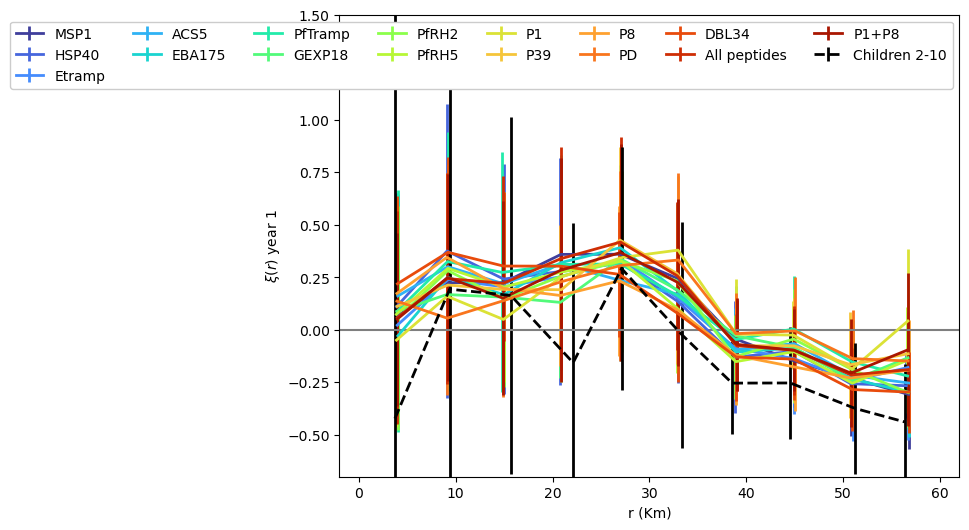

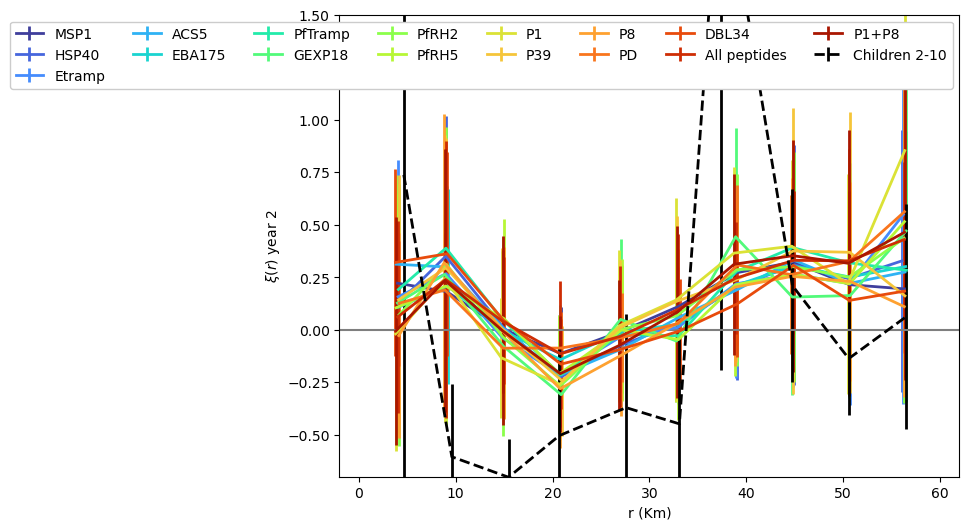

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/spatial_tools-1.0-py3.8.egg/spatial_tools/clustering.py:183: RuntimeWarning: invalid value encountered in divide


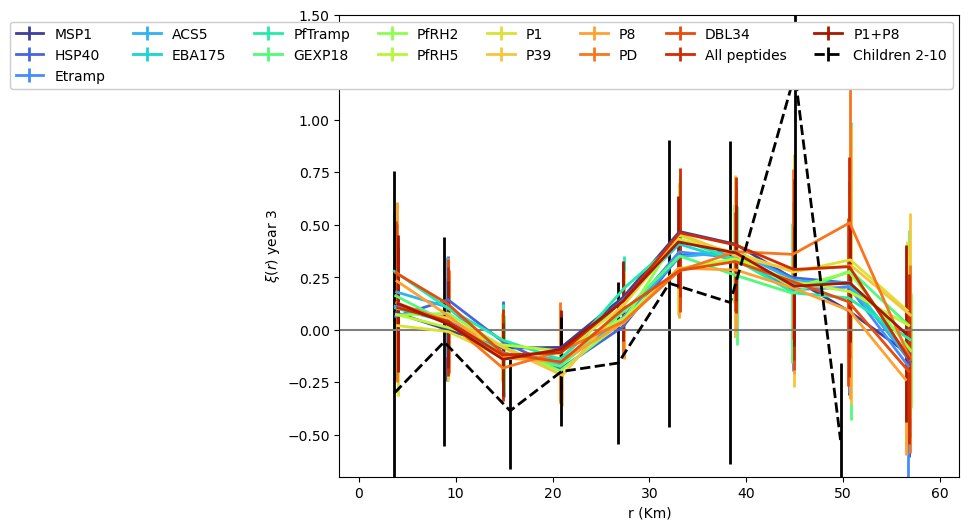

Time taken  529.0925328731537  seconds ( 8 minutes)


In [7]:
#Cross, large scales, cross-correlated with qPCR from children 2-10
cutoff = 'FMM_'
antigens_2pcf = antigens
antigens_2pcf = [cutoff + i for i in antigens_2pcf]

start = time()
mip_2pcf_y_x, mean_bin_mip_y_x, edges_y_x, mip_err_y_x, cross_2pcf_x, mean_bin_cross_x, edges, cross_err_x = \
get_all_2pcf_years_sero_cross(mipmon, mip_pcrpos, antigens_2pcf, prenatal, cross210, cross210_pcrpos, \
                   has_pcr_cross210&cross210_area_mask, bins, ranges, nrands, colors_mipmon, 'k', figsize = [8, 6], \
                   mode = 'cross', ylims = [-.7,1.5])

end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

### Consistency analysis:

$\chi²$ Statistics will be obtained comparing the 2PCF measurement in children with the different populations of pregnant women. Values larger than a chi2 threshold will be considered as different results between the two populations. Alternatively, t-test statistics will be used for the same purpose (they should give the same conclusions).

In [8]:
chi2_y_x = {}
for y in years:
    chi2_y_x[str(y)] = {}
    for s in antigens_2pcf:
        mask = (cross_err_x[str(y)]**2 > 0)&(mip_err_y_x[str(y)][s]**2 > 0)
        chi2_y_x[str(y)][s] = errors.chi_square(cross_2pcf_x[str(y)][mask], cross_err_x[str(y)][mask], mip_2pcf_y_x[str(y)][s][mask], mip_err_y_x[str(y)][s][mask])
chi2_y_x = pd.DataFrame(chi2_y_x)

In [9]:
##Cross-correlating qPCR in children with serology
chi2_y_x

,1,2,3
FMM_MSP1,0.158015,1.091287,0.444354
FMM_HSP40,0.108753,0.694947,0.467707
FMM_Etramp,0.122564,0.613136,0.403859
FMM_ACS5,0.147246,1.044655,0.564643
FMM_EBA175,0.135331,0.885500,0.432670
FMM_PfTramp,0.200788,1.066792,0.621183
FMM_GEXP18,0.184953,0.742699,0.374051
FMM_PfRH2,0.138032,0.593009,0.534800
FMM_PfRH5,0.138657,0.629593,0.518608
FMM_P1,0.317191,0.740344,0.597577


###  Significance analysis:

A t-test will be used to measure the statistical significance of the clustering signal of the different populations by measuring the deviation of the 2PCFs from zero. A table will be created describing the p-values of each population and year to identify the most significant clustering structures found.

In [10]:
def chi22p(chi2, dof):
    """This method translates from chi square statistics
    to p-value to get statistical significancy.
    
    Parameters:
    -----------
    chi2: float
        Value of chi square
    dof: int
        Number of degrees of freedom
    
    Returns:
    --------
    p: float
        P-value of statistical significance of the difference
    """
    p = 1 - sci_stats.chi2.cdf(chi2, dof)
    return p

In [11]:
sig_cross_x = {}
p_cross_x = {}
for y in years:
    sig_cross_x[str(y)] = {}
    p_cross_x[str(y)] = {}
    mask = cross_err_x[str(y)]**2 > 0
    sig_cross_x[str(y)]['qPCR data'] = errors.chi_square(cross_2pcf_x[str(y)][mask], cross_err_x[str(y)][mask], \
                                                           0*cross_2pcf_x[str(y)][mask], 0*cross_err_x[str(y)][mask])
    p_cross_x[str(y)]['qPCR data'] = chi22p(sig_cross_x[str(y)]['qPCR data']*bins, bins)
sig_cross_x = pd.DataFrame(sig_cross_x)
p_cross_x = pd.DataFrame(p_cross_x)


In [12]:
sig_cross_x

,1,2,3
qPCR data,0.636313,2.274609,0.730572


In [13]:
p_cross_x

,1,2,3
qPCR data,0.783888,0.011724,0.696302


In [14]:
sig_y_x = {}
p_y_x = {}
for y in years:
    sig_y_x[str(y)] = {}
    p_y_x[str(y)] = {}
    for s in antigens_2pcf:
        mask = mip_err_y_x[str(y)][s]**2 > 0
        sig_y_x[str(y)][s] = errors.chi_square(mip_2pcf_y_x[str(y)][s][mask], mip_err_y_x[str(y)][s][mask], \
                                             0*mip_2pcf_y_x[str(y)][s][mask], 0*mip_err_y_x[str(y)][s][mask])
        p_y_x[str(y)][s] = chi22p(sig_y_x[str(y)][s]*bins, bins)
sig_y_x = pd.DataFrame(sig_y_x)
p_y_x = pd.DataFrame(p_y_x)

In [15]:
sig_y_x

,1,2,3
FMM_MSP1,0.621937,0.277959,0.856057
FMM_HSP40,0.706115,0.211061,0.790574
FMM_Etramp,0.356172,0.179536,0.587878
FMM_ACS5,0.431375,0.457650,0.958789
FMM_EBA175,0.685432,0.176429,0.668459
FMM_PfTramp,0.304941,0.532886,1.393637
FMM_GEXP18,0.451617,0.500502,0.473394
FMM_PfRH2,0.637450,0.254887,1.306313
FMM_PfRH5,0.452865,0.270966,0.576559
FMM_P1,0.433489,0.463368,0.840774


In [16]:
p_y_x

,1,2,3
FMM_MSP1,0.796508,0.986146,0.574251
FMM_HSP40,0.719659,0.995420,0.638044
FMM_Etramp,0.964961,0.997682,0.825343
FMM_ACS5,0.932085,0.917617,0.477361
FMM_EBA175,0.739123,0.997848,0.754848
FMM_PfTramp,0.980237,0.868156,0.175914
FMM_GEXP18,0.921073,0.890843,0.908228
FMM_PfRH2,0.782879,0.990144,0.220164
FMM_PfRH5,0.920365,0.987456,0.834558
FMM_P1,0.930977,0.914269,0.589075
